https://www.kaggle.com/competitions/foursquare-location-matching/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd

In [2]:
df_train  = pd.read_csv("./data-foursquare-location-matching/train.csv")
df_test   = pd.read_csv("./data-foursquare-location-matching/test.csv")
df_pairs  = pd.read_csv("./data-foursquare-location-matching/pairs.csv")
df_sample = pd.read_csv("./data-foursquare-location-matching/sample_submission.csv")

# 1. Training data
---
## The train set: `train.csv`

In [3]:
df_train.sample(3)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
909455,E_cc5027a5efb8e4,DS Body Building Gym & Fitness,-6.888272,107.621132,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_25e2ae637290cf
943352,E_d3e7312539cec0,Binario 2,45.596702,10.123376,Via Risorgimento 15,Rodengo Saiano,NaN,25050,IT,NaN,NaN,Pizza Places,P_8e63a782abbec3
990031,E_de68aee8244654,True Shop,13.791298,100.549560,BigC Saphan Kwai,Phaya Thai,Bangkok,10400,TH,NaN,NaN,"Mobile Phone Shops, Electronics Stores",P_df923628f1264f


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1138812 non-null  object 
 1   name               1138811 non-null  object 
 2   latitude           1138812 non-null  float64
 3   longitude          1138812 non-null  float64
 4   address            742191 non-null   object 
 5   city               839623 non-null   object 
 6   state              718226 non-null   object 
 7   zip                543386 non-null   object 
 8   country            1138801 non-null  object 
 9   url                267724 non-null   object 
 10  phone              342855 non-null   object 
 11  categories         1040505 non-null  object 
 12  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(11)
memory usage: 112.9+ MB


### Missing values in the train set
- Every row has the features: `id`, `latitude`, `longitude`, `point_of_interest`
- Other features have missing values
- Features that have less missing values: `name`, `country`, `categories`

In [5]:
# Count the missing values
missing = df_train.isna().sum()/df_train.shape[0]*100
missing.sort_values()

id                    0.000000
latitude              0.000000
longitude             0.000000
point_of_interest     0.000000
name                  0.000088
country               0.000966
categories            8.632417
city                 26.272027
address              34.827610
state                36.931996
zip                  52.284837
phone                69.893626
url                  76.490940
dtype: float64

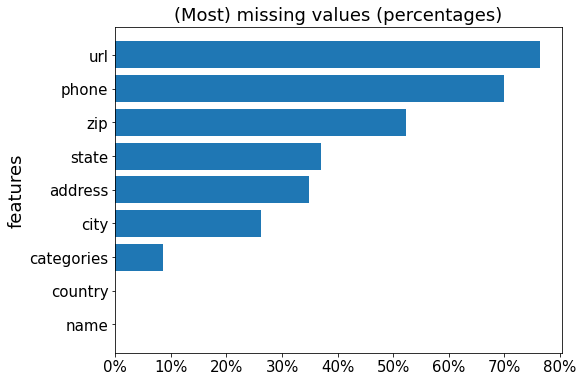

In [6]:
# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df_train.drop(columns=['id','latitude','longitude','point_of_interest']).isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(tmp.index, tmp/len(df_train)*100)
ax.set_title("(Most) missing values (percentages)", fontsize=18)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
plt.show()

In [7]:
# Take a look at the stupid outliers
df_train[df_train['country'].isna()].head(3)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
45891,E_0a44b45f734139,"Markham, Maerua Mall",-22.583108,17.093568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Men's Stores,P_845763d172f88e
201697,E_2d417f61d76741,Wernhill Park,-22.567297,17.082069,NaN,Windhoek,Khomas,NaN,NaN,NaN,NaN,Shopping Malls,P_5ffceb1c2ec3cd
253807,E_3900936ca2996a,Hilton Windhoek,-22.570327,17.085307,Rev. Michael Scott Street,Windhoek,Khomas,70,NaN,http://windhoek.hilton.com,612962929,NaN,P_d7df3f321a984f


In [8]:
# Take a look at the stupid outliers
df_train[df_train['name'].isna()]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
750648,E_a8a20800af4423,NaN,40.822332,-96.689102,NaN,NaN,AK,NaN,US,NaN,NaN,NaN,P_be5d12315d8588


The `id` feature is unique:

In [9]:
len(df_train['id'].unique()) == len(df_train)

True

In [10]:
print('Number of (unique) POIs : {:8d}'.format(len(df_train['point_of_interest'].unique())))
print('Number of (unique) ids  : {:8d}'.format(len(df_train['id'].unique())))

Number of (unique) POIs :   739972
Number of (unique) ids  :  1138812


#### Notes on the `point_of_interest` feature:

https://www.kaggle.com/competitions/foursquare-location-matching/discussion/318967#1783581

In [11]:
mask = (df_train['country'] == 'US')
print(len(df_train[df_train['zip'].isna()  & mask]))
print(len(df_train[df_train['state'].isna()& mask]))
print(len(df_train[df_train['city'].isna() & mask]))
print(len(df_train[df_train['zip'].isna() & df_train['state'].isna() & df_train['city'].isna() & mask]))

32007
5911
9043
5263


### Latitude and longitude
Data concentrate on the US and the Europe: 

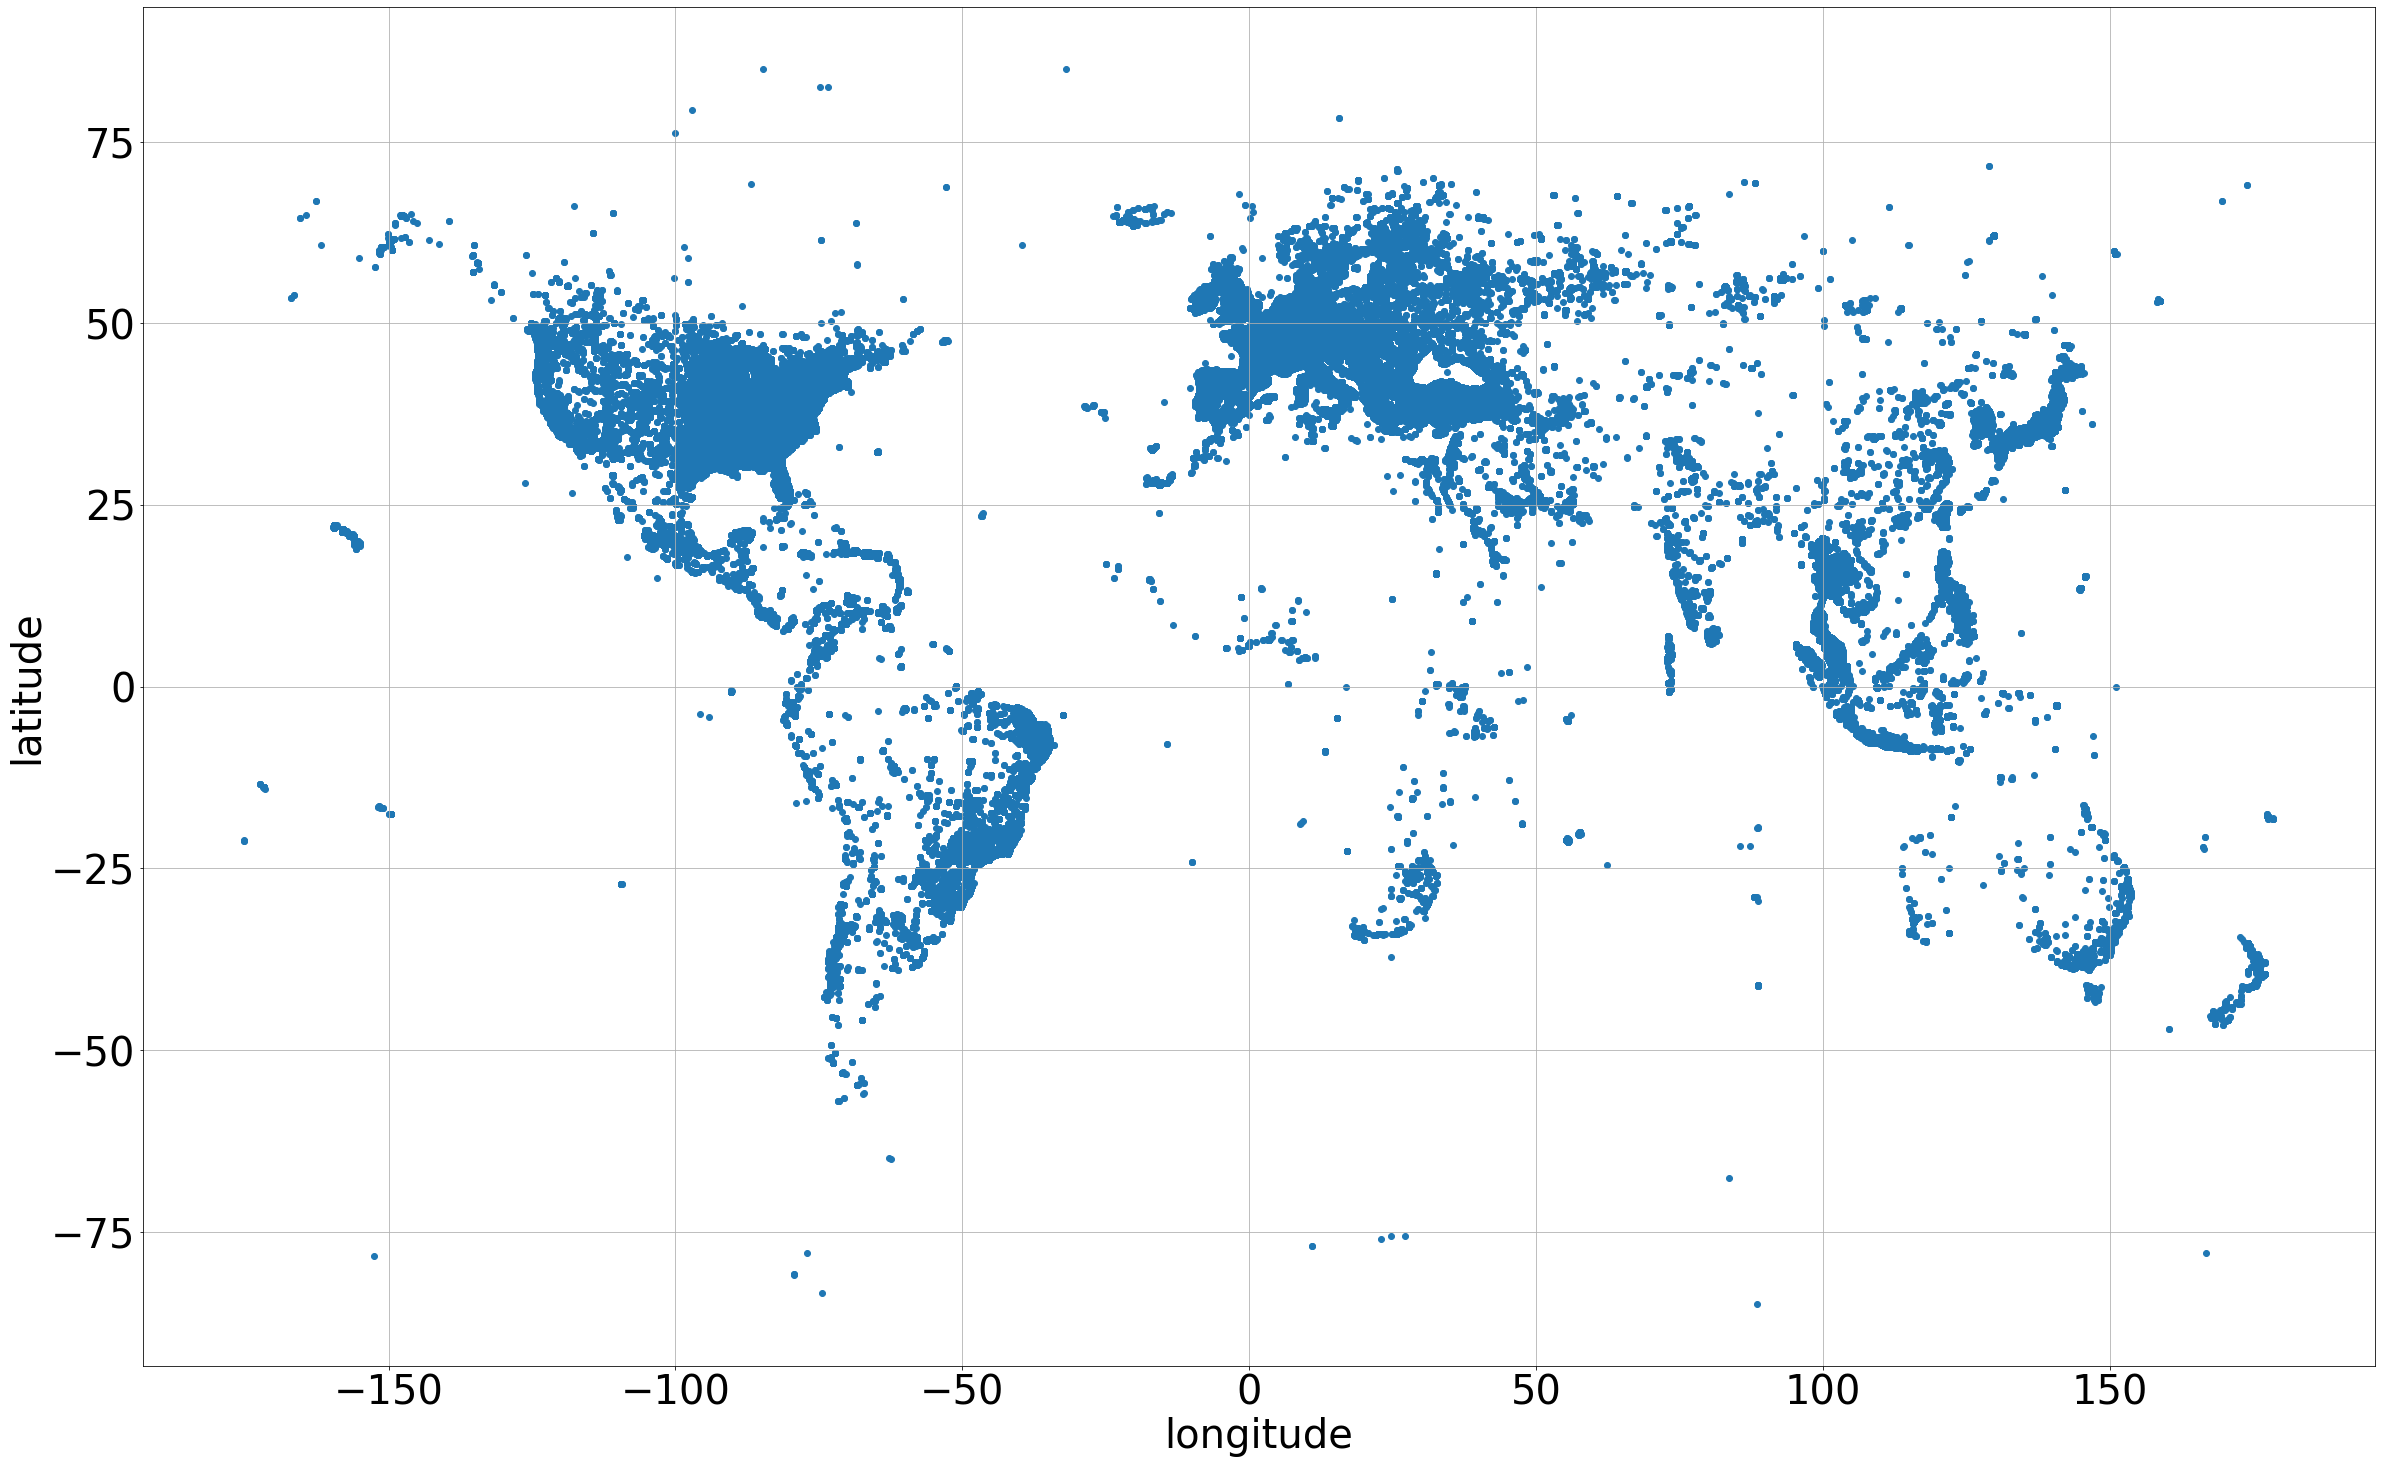

In [12]:
fig, ax = plt.subplots(figsize=(40,25))
ax.scatter(df_train['longitude'],df_train['latitude'])
ax.set_xlabel('longitude',fontsize=40)
ax.set_ylabel('latitude',fontsize=40)
ax.tick_params(axis='both', labelsize=40)
ax.grid()
plt.show()

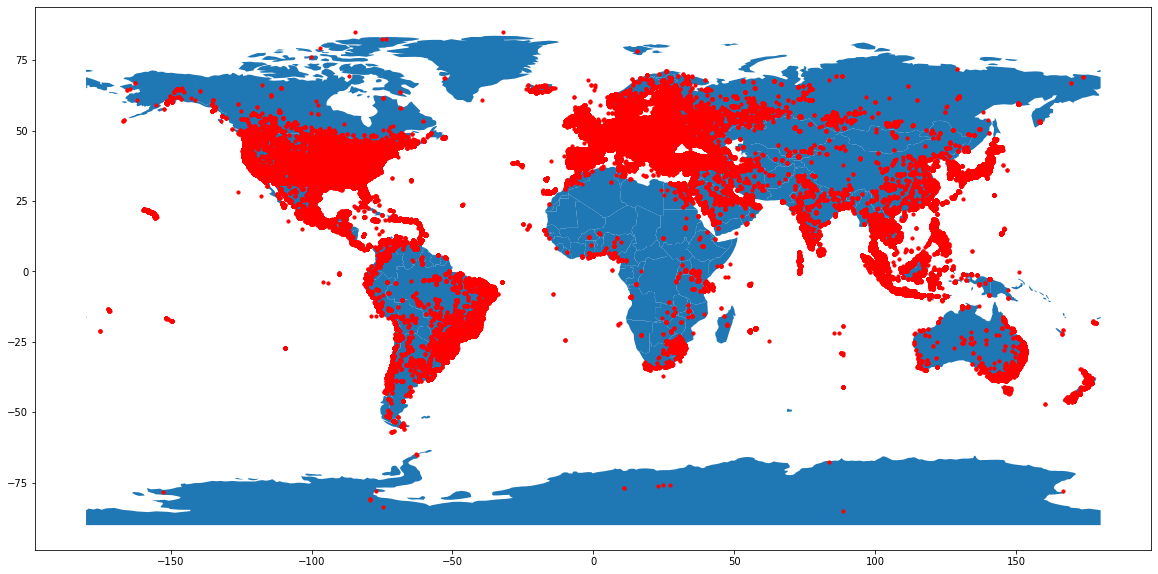

In [13]:
geometry = [Point(xy) for xy in zip(df_train['longitude'], df_train['latitude'])]
gdf = GeoDataFrame(df_train.copy(), geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(20, 12)), marker='o', color='red', markersize=10)
plt.show()

### Question

Do those points in the ocean mean inaccurate latitude-longitude data? Maybe there are islands there.

## The set of pairs: `pairs.csv`

In [14]:
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578907 entries, 0 to 578906
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_1          578907 non-null  object 
 1   name_1        578907 non-null  object 
 2   latitude_1    578907 non-null  float64
 3   longitude_1   578907 non-null  float64
 4   address_1     475383 non-null  object 
 5   city_1        512928 non-null  object 
 6   state_1       452316 non-null  object 
 7   zip_1         359509 non-null  object 
 8   country_1     578899 non-null  object 
 9   url_1         231806 non-null  object 
 10  phone_1       270022 non-null  object 
 11  categories_1  562613 non-null  object 
 12  id_2          578907 non-null  object 
 13  name_2        578907 non-null  object 
 14  latitude_2    578907 non-null  float64
 15  longitude_2   578907 non-null  float64
 16  address_2     312497 non-null  object 
 17  city_2        367490 non-null  object 
 18  stat

### `pairs.csv` and `train.csv` (Redundant. To be deleted. Already in the Kaggle description.)
We verify that all place "entries" in `pairs.csv` are from `train.csv`. 

In [15]:
# Make a copy of df_pairs
# Rename the columns in df_pairs_copy with the names in train.csv
df_pairs_copy = df_pairs.copy(deep=True)
for x in df_pairs_copy.columns:
    df_pairs_copy.rename({x:x.split('_')[0]},axis='columns',inplace=True)

In [16]:
df_pairs_copy.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories', 'id', 'name',
       'latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country',
       'url', 'phone', 'categories', 'match'],
      dtype='object')

In [17]:
# Reshape df_pairs_copy to compare it with df_train (train set)
# The reshape data framed is tmp
tmp1 = df_pairs_copy.iloc[:,:12]
tmp2 = df_pairs_copy.iloc[:,12:-1]
tmp  = pd.concat([tmp1,tmp2])
# tmp.shape[0] == tmp1.shape[0]+tmp2.shape[0]
print('Number of ids in pairs.csv:        {}'.format(tmp.shape[0]))
print('Number of unique ids in pairs.csv: {}'.format(len(tmp['id'].unique())))
print('Number of ids in train.csv:        {}'.format(df_train.shape[0]))
print('The set of ids in pairs.csv is a subset of those in the train set: {}'
      .format(set(tmp['id']).issubset(set(df_train['id']))))

Number of ids in pairs.csv:        1157814
Number of unique ids in pairs.csv: 1008661
Number of ids in train.csv:        1138812
The set of ids in pairs.csv is a subset of those in the train set: True


In [18]:
# tmp is too big. Take random samples to compare with entries in train.csv
tmp_sample = tmp.sample(100)
flag = True
for i in range(len(tmp_sample)):
    s_pairs = tmp_sample.iloc[i,:]
    s_train = df_train[df_train['id']==s_pairs[0]]
    s_train = s_train.iloc[0,:-1]
    s_pairs.notna() == s_train.notna()
    if not all(s_pairs.notna() == s_train.notna()): 
        print('Oops')
        flag = False
        break
    if i%10 == 0: print(i)
if flag: print("All random samples are from train.csv")

0
10
20
30
40
50
60
70
80
90
All random samples are from train.csv


# Availability of data by country


In [19]:
country_stats = df_train['country'].value_counts()*100/df_train['country'].value_counts().sum()
country_stats = country_stats.head(10).sort_values()
country_stats.shape

(10,)

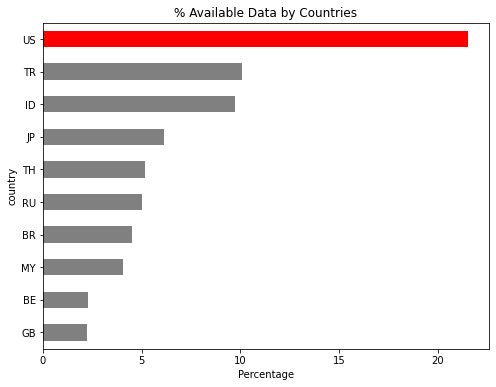

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(country_stats.index)
color[-1] = "red"
country_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("% Available Data by Countries")
ax.set_ylabel('country')
ax.set_xlabel('Percentage')
plt.show()

In [21]:
# import plotly

# fig = go.Figure(data=go.Choropleth(
#     locations = country_stats['country'],
#     z = country_stats['% data'],
#     text = country_stats['country'],
#     colorscale = 'greens',
#     autocolorscale=False,
#     marker_line_color='lightgray',
#     marker_line_width=0.5,
#     colorbar_tickprefix = '%',
#     colorbar_title = 'Data availability',
# ))
# fig.update_layout(title_text='% Data by Country')
# fig.show()

# The US data

In [22]:
df_us = df_train[df_train['country']=='US']

In [23]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245284 entries, 8 to 1138808
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 245284 non-null  object 
 1   name               245283 non-null  object 
 2   latitude           245284 non-null  float64
 3   longitude          245284 non-null  float64
 4   address            188824 non-null  object 
 5   city               236241 non-null  object 
 6   state              239373 non-null  object 
 7   zip                213277 non-null  object 
 8   country            245284 non-null  object 
 9   url                99477 non-null   object 
 10  phone              131597 non-null  object 
 11  categories         232133 non-null  object 
 12  point_of_interest  245284 non-null  object 
dtypes: float64(2), object(11)
memory usage: 26.2+ MB


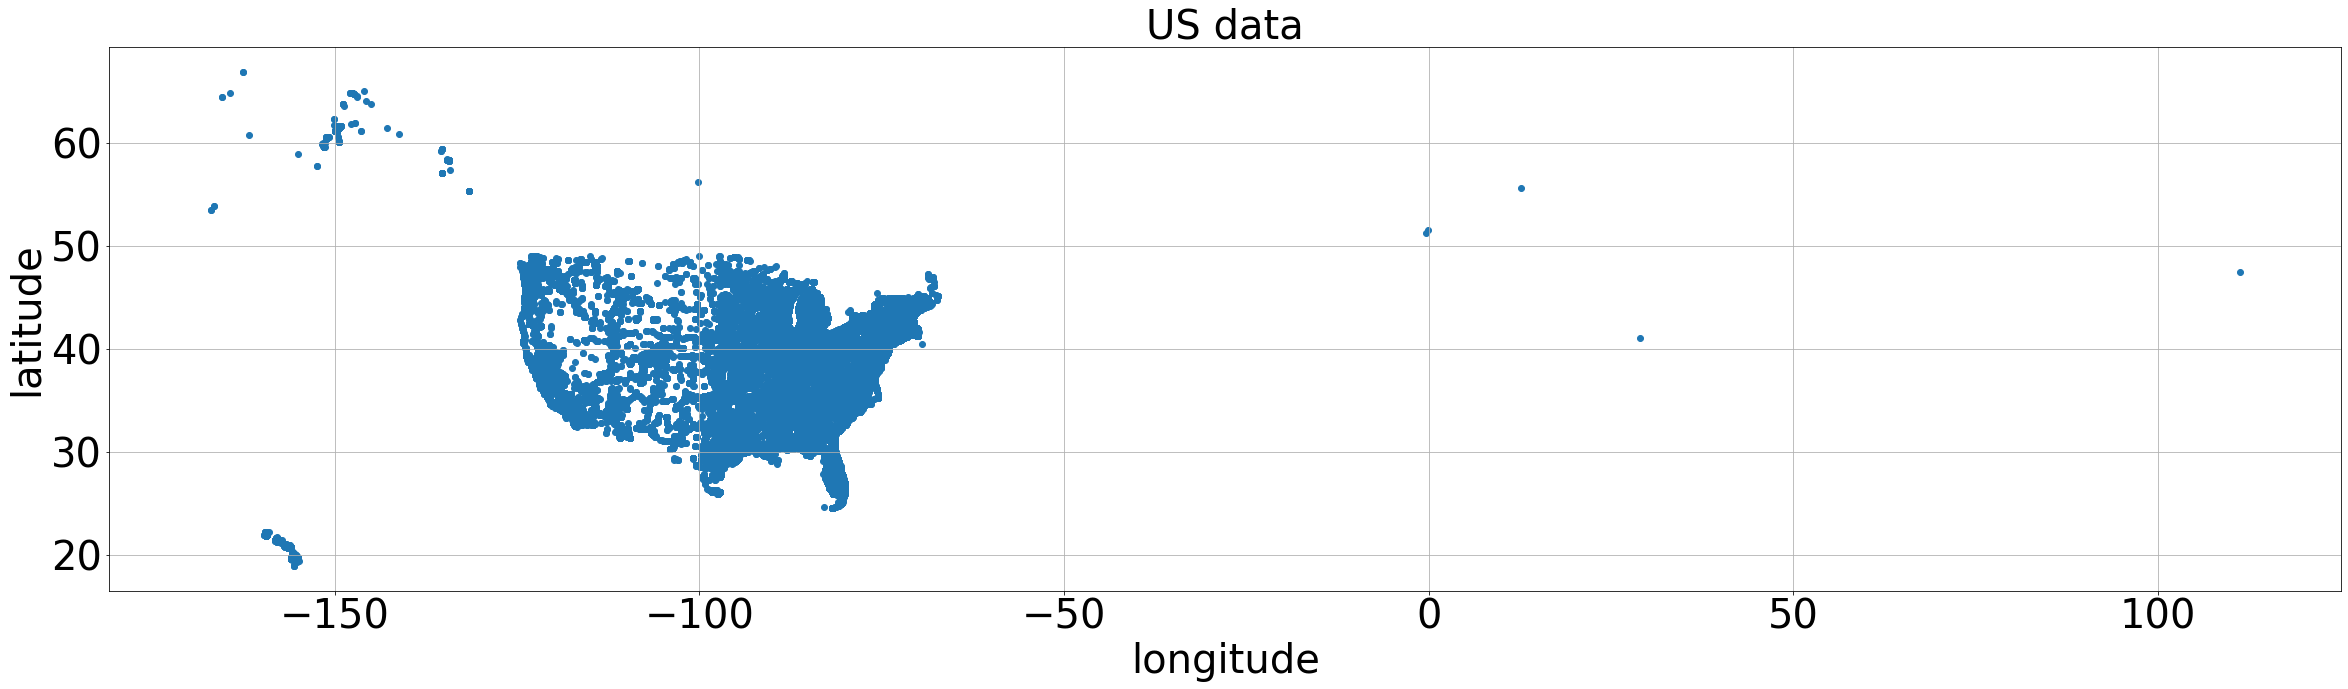

In [24]:
fig, ax = plt.subplots(figsize=(40,10))
ax.scatter(df_us['longitude'],df_us['latitude'])
ax.set_xlabel('longitude',fontsize=40)
ax.set_ylabel('latitude',fontsize=40)
ax.tick_params(axis='both', labelsize=40)
ax.set_title('US data',fontsize=40)
ax.grid()
plt.show()

In [25]:
df_us[df_us['longitude']>-50]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
182570,E_28f6a8c1810d42,Copenhagen Airport (CPH),55.613190,12.647946,NaN,Copenhagen,Capital Region of Denmark,NaN,US,NaN,NaN,Airports,P_de322dff6e3a8b
411088,E_5c62949becf17d,"u.s. post office. Roland Park, Maryland",51.227604,-0.322765,Deepdene Avenue,NaN,NaN,NaN,US,http://www.postoffice.co.uk,NaN,Post Offices,P_c15c1ca3fd79fc
802054,E_b41d3d0482fa69,The App Business,51.531921,-0.119336,71 Collier Street,London,London,N1 9BE,US,http://www.theappbusiness.com,+442036579785,Tech Startups,P_91619d1673cbad
973858,E_dac30d0d02c283,Ashley HomeStore,47.492458,111.230481,4500 10th Ave S,Great Falls,MT,59405,US,https://stores.ashleyfurniture.com/store/us/mo...,4069521950,Furniture / Home Stores,P_445cfb4d88156e
1067601,E_eff18c64b0035b,Caffè Nero,41.068343,29.006095,Büyükdere Caddesi Astoria Alışveriş Merkezi Es...,İstanbul,NaN,NaN,US,NaN,NaN,Coffee Shops,P_03e3feca1ddcc5
